# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm
import matplotlib

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-09f99c36-5ffe-a2f0-eaaa-1003965837d8)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#
sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)


# Three data we have to train
#train_dataloader, sixteenth_train_dataloader,half_train_dataloader

100%|██████████| 170498071/170498071 [00:01<00:00, 97892215.08it/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Load Models

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.

num_classes = 10;
model.fc = nn.Linear(model.fc.in_features, num_classes);


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
#This line transfers the model's parameters (e.g., weights and biases) to the selected device.
#This is important when working with GPU acceleration because it ensures that the model's operations are performed on the chosen device.
model = model.to(device)




### Training and Testing Models

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()
    con=0
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        con=con+len(y);
        # Compute prediction error
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / con

    return avg_epoch_loss, avg_acc

In [ ]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

###### Resnet18 with three type of data input

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];

epochs = 100
for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Epoch  1: Loss = 1.5585 Acc = 0.43 Test_Loss = 1.3297 Test_Acc = 0.53


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch  2: Loss = 1.1972 Acc = 0.57 Test_Loss = 1.1902 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch  3: Loss = 1.0412 Acc = 0.63 Test_Loss = 1.0907 Test_Acc = 0.62


100%|██████████| 40/40 [00:02<00:00, 13.64it/s]


Epoch  4: Loss = 0.9396 Acc = 0.67 Test_Loss = 1.1337 Test_Acc = 0.62


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


Epoch  5: Loss = 0.8563 Acc = 0.70 Test_Loss = 0.8919 Test_Acc = 0.69


100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


Epoch  6: Loss = 0.7977 Acc = 0.72 Test_Loss = 0.8116 Test_Acc = 0.72


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Epoch  7: Loss = 0.7520 Acc = 0.74 Test_Loss = 0.7368 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


Epoch  8: Loss = 0.7099 Acc = 0.75 Test_Loss = 0.7064 Test_Acc = 0.75


100%|██████████| 40/40 [00:02<00:00, 13.87it/s]


Epoch  9: Loss = 0.6741 Acc = 0.76 Test_Loss = 0.6918 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.97it/s]


Epoch 10: Loss = 0.6379 Acc = 0.78 Test_Loss = 0.6870 Test_Acc = 0.76


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 11: Loss = 0.6103 Acc = 0.79 Test_Loss = 0.7909 Test_Acc = 0.74


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 12: Loss = 0.5906 Acc = 0.79 Test_Loss = 0.6936 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 12.34it/s]


Epoch 13: Loss = 0.5708 Acc = 0.80 Test_Loss = 0.6276 Test_Acc = 0.78


100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 14: Loss = 0.5496 Acc = 0.81 Test_Loss = 0.6214 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.86it/s]


Epoch 15: Loss = 0.5287 Acc = 0.82 Test_Loss = 0.6606 Test_Acc = 0.78


100%|██████████| 40/40 [00:02<00:00, 14.19it/s]


Epoch 16: Loss = 0.5166 Acc = 0.82 Test_Loss = 0.6209 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch 17: Loss = 0.4982 Acc = 0.82 Test_Loss = 0.6255 Test_Acc = 0.79


100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


Epoch 18: Loss = 0.4813 Acc = 0.83 Test_Loss = 0.6363 Test_Acc = 0.79


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 19: Loss = 0.4730 Acc = 0.83 Test_Loss = 0.6052 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 20: Loss = 0.4549 Acc = 0.84 Test_Loss = 0.5668 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 21: Loss = 0.4406 Acc = 0.85 Test_Loss = 0.5648 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.91it/s]


Epoch 22: Loss = 0.4310 Acc = 0.85 Test_Loss = 0.5635 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch 23: Loss = 0.4206 Acc = 0.85 Test_Loss = 0.5882 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


Epoch 24: Loss = 0.4088 Acc = 0.86 Test_Loss = 0.5415 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 25: Loss = 0.3974 Acc = 0.86 Test_Loss = 0.5662 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 14.47it/s]


Epoch 26: Loss = 0.3913 Acc = 0.86 Test_Loss = 0.5589 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Epoch 27: Loss = 0.3820 Acc = 0.87 Test_Loss = 0.5970 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 14.02it/s]


Epoch 28: Loss = 0.3739 Acc = 0.87 Test_Loss = 0.5644 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Epoch 29: Loss = 0.3604 Acc = 0.87 Test_Loss = 0.5675 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 14.07it/s]


Epoch 30: Loss = 0.3537 Acc = 0.87 Test_Loss = 0.5918 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.94it/s]


Epoch 31: Loss = 0.3471 Acc = 0.88 Test_Loss = 0.5794 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 32: Loss = 0.3336 Acc = 0.88 Test_Loss = 0.5521 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.62it/s]


Epoch 33: Loss = 0.3304 Acc = 0.88 Test_Loss = 0.5707 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 34: Loss = 0.3201 Acc = 0.89 Test_Loss = 0.6195 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


Epoch 35: Loss = 0.3102 Acc = 0.89 Test_Loss = 0.5308 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]


Epoch 36: Loss = 0.3116 Acc = 0.89 Test_Loss = 0.5511 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.55it/s]


Epoch 37: Loss = 0.3026 Acc = 0.89 Test_Loss = 0.5458 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 38: Loss = 0.2909 Acc = 0.90 Test_Loss = 0.5318 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.95it/s]


Epoch 39: Loss = 0.2812 Acc = 0.90 Test_Loss = 0.5588 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 14.08it/s]


Epoch 40: Loss = 0.2765 Acc = 0.90 Test_Loss = 0.6076 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


Epoch 41: Loss = 0.2736 Acc = 0.90 Test_Loss = 0.5549 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 14.19it/s]


Epoch 42: Loss = 0.2595 Acc = 0.91 Test_Loss = 0.5461 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.14it/s]


Epoch 43: Loss = 0.2635 Acc = 0.91 Test_Loss = 0.5655 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.94it/s]


Epoch 44: Loss = 0.2578 Acc = 0.91 Test_Loss = 0.5678 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.15it/s]


Epoch 45: Loss = 0.2424 Acc = 0.91 Test_Loss = 0.5868 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Epoch 46: Loss = 0.2471 Acc = 0.91 Test_Loss = 0.5669 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.55it/s]


Epoch 47: Loss = 0.2391 Acc = 0.92 Test_Loss = 0.5545 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 48: Loss = 0.2289 Acc = 0.92 Test_Loss = 0.6064 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 14.24it/s]


Epoch 49: Loss = 0.2272 Acc = 0.92 Test_Loss = 0.5789 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 50: Loss = 0.2178 Acc = 0.92 Test_Loss = 0.5875 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.87it/s]


Epoch 51: Loss = 0.2172 Acc = 0.92 Test_Loss = 0.6005 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.23it/s]


Epoch 52: Loss = 0.2144 Acc = 0.92 Test_Loss = 0.6192 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 13.13it/s]


Epoch 53: Loss = 0.2091 Acc = 0.93 Test_Loss = 0.5928 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.20it/s]


Epoch 54: Loss = 0.2047 Acc = 0.93 Test_Loss = 0.6025 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.62it/s]


Epoch 55: Loss = 0.1965 Acc = 0.93 Test_Loss = 0.6227 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 14.22it/s]


Epoch 56: Loss = 0.2004 Acc = 0.93 Test_Loss = 0.6299 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 57: Loss = 0.1921 Acc = 0.93 Test_Loss = 0.6044 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 58: Loss = 0.1902 Acc = 0.93 Test_Loss = 0.6088 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.87it/s]


Epoch 59: Loss = 0.1834 Acc = 0.93 Test_Loss = 0.6019 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 60: Loss = 0.1786 Acc = 0.94 Test_Loss = 0.6019 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 61: Loss = 0.1801 Acc = 0.94 Test_Loss = 0.6098 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 62: Loss = 0.1761 Acc = 0.94 Test_Loss = 0.6595 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.87it/s]


Epoch 63: Loss = 0.1726 Acc = 0.94 Test_Loss = 0.6566 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.53it/s]


Epoch 64: Loss = 0.1700 Acc = 0.94 Test_Loss = 0.6340 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.01it/s]


Epoch 65: Loss = 0.1666 Acc = 0.94 Test_Loss = 0.6364 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.19it/s]


Epoch 66: Loss = 0.1626 Acc = 0.94 Test_Loss = 0.6666 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 67: Loss = 0.1638 Acc = 0.94 Test_Loss = 0.6403 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.99it/s]


Epoch 68: Loss = 0.1531 Acc = 0.94 Test_Loss = 0.6473 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]


Epoch 69: Loss = 0.1512 Acc = 0.95 Test_Loss = 0.6711 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.95it/s]


Epoch 70: Loss = 0.1535 Acc = 0.95 Test_Loss = 0.6604 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.07it/s]


Epoch 71: Loss = 0.1467 Acc = 0.95 Test_Loss = 0.6685 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 72: Loss = 0.1416 Acc = 0.95 Test_Loss = 0.6293 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 73: Loss = 0.1425 Acc = 0.95 Test_Loss = 0.6600 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.28it/s]


Epoch 74: Loss = 0.1349 Acc = 0.95 Test_Loss = 0.6493 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.62it/s]


Epoch 75: Loss = 0.1394 Acc = 0.95 Test_Loss = 0.6942 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.43it/s]


Epoch 76: Loss = 0.1367 Acc = 0.95 Test_Loss = 0.7057 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.58it/s]


Epoch 77: Loss = 0.1325 Acc = 0.95 Test_Loss = 0.6806 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 78: Loss = 0.1331 Acc = 0.95 Test_Loss = 0.6925 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.93it/s]


Epoch 79: Loss = 0.1242 Acc = 0.96 Test_Loss = 0.6899 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.79it/s]


Epoch 80: Loss = 0.1262 Acc = 0.95 Test_Loss = 0.7247 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


Epoch 81: Loss = 0.1250 Acc = 0.96 Test_Loss = 0.6748 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.23it/s]


Epoch 82: Loss = 0.1224 Acc = 0.96 Test_Loss = 0.7056 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 83: Loss = 0.1169 Acc = 0.96 Test_Loss = 0.7090 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.22it/s]


Epoch 84: Loss = 0.1204 Acc = 0.96 Test_Loss = 0.6885 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 85: Loss = 0.1133 Acc = 0.96 Test_Loss = 0.6996 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.49it/s]


Epoch 86: Loss = 0.1211 Acc = 0.96 Test_Loss = 0.7202 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


Epoch 87: Loss = 0.1161 Acc = 0.96 Test_Loss = 0.7249 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.93it/s]


Epoch 88: Loss = 0.1101 Acc = 0.96 Test_Loss = 0.7174 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.99it/s]


Epoch 89: Loss = 0.1182 Acc = 0.96 Test_Loss = 0.7106 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 90: Loss = 0.1159 Acc = 0.96 Test_Loss = 0.7150 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.98it/s]


Epoch 91: Loss = 0.1067 Acc = 0.96 Test_Loss = 0.7209 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 92: Loss = 0.1048 Acc = 0.96 Test_Loss = 0.7466 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.12it/s]


Epoch 93: Loss = 0.1031 Acc = 0.96 Test_Loss = 0.7474 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Epoch 94: Loss = 0.1013 Acc = 0.96 Test_Loss = 0.7249 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.64it/s]


Epoch 95: Loss = 0.1010 Acc = 0.96 Test_Loss = 0.7698 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.01it/s]


Epoch 96: Loss = 0.0984 Acc = 0.96 Test_Loss = 0.7172 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 14.06it/s]


Epoch 97: Loss = 0.0976 Acc = 0.97 Test_Loss = 0.7307 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


Epoch 98: Loss = 0.0966 Acc = 0.97 Test_Loss = 0.7872 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


Epoch 99: Loss = 0.0968 Acc = 0.96 Test_Loss = 0.7439 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 14.09it/s]

Epoch 100: Loss = 0.0928 Acc = 0.97 Test_Loss = 0.7508 Test_Acc = 0.85
Done!


In [ ]:
#matplotlib.use('Agg')
t = [];
for i in range(len(save_train_acc)):
  t.append(i);
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet18_whole_Acc_curve.png')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("test_loss and train_loss for train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet18_whole_loss_curve.png')
plt.clf()

torch.save(model.state_dict(), "model_resnet18_train_data_loader_100iterations.pth")

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)

num_classes = 10;
model.fc = nn.Linear(model.fc.in_features, num_classes);
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];

epochs = 100

for epoch in range(epochs):
    train_loss, train_acc = train(sixteenth_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

In [ ]:
t = [];
for i in range(len(save_train_acc)):
  t.append(i);

matplotlib.use('Agg')
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for sixteenth_train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet18_16_Acc_curve.png')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("test_loss and train_loss for sixteenth_train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet18_16_loss_curve.png')
plt.clf()
torch.save(model.state_dict(), "model_resnet18_sixteenth_train_dataloader_30iterations.pth")

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)

num_classes = 10;
model.fc = nn.Linear(model.fc.in_features, num_classes);
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];
epochs = 50

for epoch in range(epochs):
    train_loss, train_acc = train(half_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")




100%|██████████| 40/40 [00:02<00:00, 13.48it/s]


Epoch  1: Loss = 1.7124 Acc = 0.37 Test_Loss = 1.5794 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


Epoch  2: Loss = 1.3888 Acc = 0.49 Test_Loss = 1.3267 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch  3: Loss = 1.2413 Acc = 0.56 Test_Loss = 1.1528 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


Epoch  4: Loss = 1.1365 Acc = 0.59 Test_Loss = 1.2211 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 13.18it/s]


Epoch  5: Loss = 1.0536 Acc = 0.62 Test_Loss = 1.0152 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 12.24it/s]


Epoch  6: Loss = 0.9963 Acc = 0.64 Test_Loss = 0.9680 Test_Acc = 0.66


100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


Epoch  7: Loss = 0.9378 Acc = 0.67 Test_Loss = 0.9591 Test_Acc = 0.66


100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch  8: Loss = 0.9122 Acc = 0.68 Test_Loss = 0.8900 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 12.94it/s]


Epoch  9: Loss = 0.8597 Acc = 0.69 Test_Loss = 0.9399 Test_Acc = 0.67


100%|██████████| 40/40 [00:02<00:00, 13.34it/s]


Epoch 10: Loss = 0.8214 Acc = 0.71 Test_Loss = 0.8668 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 13.07it/s]


Epoch 11: Loss = 0.8067 Acc = 0.72 Test_Loss = 0.8076 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


Epoch 12: Loss = 0.7869 Acc = 0.72 Test_Loss = 0.7583 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


Epoch 13: Loss = 0.7407 Acc = 0.74 Test_Loss = 0.7894 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 13.17it/s]


Epoch 14: Loss = 0.7303 Acc = 0.74 Test_Loss = 0.7902 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


Epoch 15: Loss = 0.7141 Acc = 0.75 Test_Loss = 0.7758 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 13.06it/s]


Epoch 16: Loss = 0.6883 Acc = 0.76 Test_Loss = 0.7004 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 10.59it/s]


Epoch 17: Loss = 0.6776 Acc = 0.76 Test_Loss = 0.7291 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.69it/s]


Epoch 18: Loss = 0.6512 Acc = 0.77 Test_Loss = 0.7021 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


Epoch 19: Loss = 0.6339 Acc = 0.78 Test_Loss = 0.6749 Test_Acc = 0.76


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 20: Loss = 0.6258 Acc = 0.78 Test_Loss = 0.7315 Test_Acc = 0.75


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 21: Loss = 0.6171 Acc = 0.79 Test_Loss = 0.6584 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.65it/s]


Epoch 22: Loss = 0.5892 Acc = 0.79 Test_Loss = 0.6991 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 23: Loss = 0.5799 Acc = 0.80 Test_Loss = 0.6448 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 12.32it/s]


Epoch 24: Loss = 0.5682 Acc = 0.80 Test_Loss = 0.6690 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 25: Loss = 0.5552 Acc = 0.81 Test_Loss = 0.6563 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 26: Loss = 0.5481 Acc = 0.81 Test_Loss = 0.6313 Test_Acc = 0.78


 55%|█████▌    | 54/98 [00:09<00:07,  5.63it/s]


KeyboardInterrupt: ignored

In [ ]:
t = [];
for i in range(len(save_train_acc)):
  t.append(i);

matplotlib.use('Agg')
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for half_train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet18_2_Accuracy.jpg')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("test_loss and train_loss for half_train_dataloader")
plt.legend()
plt.show()

#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet18_2_loss.jpg')
plt.clf()
#torch.save(model.state_dict(), "model_resnet18_half_train_dataloader_30iterations.pth")

###### Resnet50 with three type of data input

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

num_classes = 10;
model.fc = nn.Linear(model.fc.in_features, num_classes);
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")



100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


Epoch  1: Loss = 1.9450 Acc = 0.32 Test_Loss = 1.5518 Test_Acc = 0.42


100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Epoch  2: Loss = 1.5981 Acc = 0.45 Test_Loss = 1.3589 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch  3: Loss = 1.5311 Acc = 0.46 Test_Loss = 7.7842 Test_Acc = 0.35


100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


Epoch  4: Loss = 1.4666 Acc = 0.48 Test_Loss = 1.3527 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch  5: Loss = 1.3922 Acc = 0.53 Test_Loss = 1.8836 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch  6: Loss = 1.3037 Acc = 0.54 Test_Loss = 1.1173 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


Epoch  7: Loss = 1.2620 Acc = 0.56 Test_Loss = 1.7592 Test_Acc = 0.41


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch  8: Loss = 1.3229 Acc = 0.54 Test_Loss = 1.1345 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Epoch  9: Loss = 1.1715 Acc = 0.59 Test_Loss = 1.0953 Test_Acc = 0.63


100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


Epoch 10: Loss = 1.2643 Acc = 0.56 Test_Loss = 3.5793 Test_Acc = 0.36


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch 11: Loss = 1.3786 Acc = 0.51 Test_Loss = 1.1349 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 12: Loss = 1.1642 Acc = 0.60 Test_Loss = 1.0073 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 13: Loss = 1.0736 Acc = 0.63 Test_Loss = 0.9656 Test_Acc = 0.66


100%|██████████| 40/40 [00:04<00:00,  9.71it/s]


Epoch 14: Loss = 0.9293 Acc = 0.67 Test_Loss = 0.9383 Test_Acc = 0.69


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 15: Loss = 0.9957 Acc = 0.65 Test_Loss = 1.0915 Test_Acc = 0.62


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 16: Loss = 0.9929 Acc = 0.65 Test_Loss = 1.0076 Test_Acc = 0.65


100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 17: Loss = 1.3549 Acc = 0.54 Test_Loss = 1.0139 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Epoch 18: Loss = 1.2356 Acc = 0.57 Test_Loss = 1.1582 Test_Acc = 0.61


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 19: Loss = 1.0026 Acc = 0.65 Test_Loss = 0.9187 Test_Acc = 0.68


100%|██████████| 40/40 [00:04<00:00,  9.11it/s]


Epoch 20: Loss = 1.0726 Acc = 0.63 Test_Loss = 2.0542 Test_Acc = 0.61


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 21: Loss = 1.1296 Acc = 0.62 Test_Loss = 1.1515 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 12.06it/s]


Epoch 22: Loss = 0.8626 Acc = 0.70 Test_Loss = 0.7936 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Epoch 23: Loss = 0.7887 Acc = 0.72 Test_Loss = 0.7487 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.85it/s]


Epoch 24: Loss = 0.8814 Acc = 0.70 Test_Loss = 1.5809 Test_Acc = 0.47


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 25: Loss = 1.2778 Acc = 0.56 Test_Loss = 1.0485 Test_Acc = 0.63


100%|██████████| 40/40 [00:04<00:00,  8.77it/s]


Epoch 26: Loss = 0.9261 Acc = 0.68 Test_Loss = 0.8862 Test_Acc = 0.69


100%|██████████| 40/40 [00:03<00:00, 12.28it/s]


Epoch 27: Loss = 0.7899 Acc = 0.72 Test_Loss = 0.7478 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 28: Loss = 0.7376 Acc = 0.74 Test_Loss = 0.7347 Test_Acc = 0.74


100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Epoch 29: Loss = 0.6903 Acc = 0.76 Test_Loss = 0.7041 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 30: Loss = 0.6700 Acc = 0.77 Test_Loss = 0.6827 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Epoch 31: Loss = 0.6424 Acc = 0.77 Test_Loss = 0.6611 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch 32: Loss = 0.6153 Acc = 0.78 Test_Loss = 0.6441 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 33: Loss = 0.5973 Acc = 0.79 Test_Loss = 0.6411 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 34: Loss = 0.5912 Acc = 0.79 Test_Loss = 0.6451 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  8.53it/s]


Epoch 35: Loss = 0.5623 Acc = 0.80 Test_Loss = 0.6209 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 36: Loss = 0.5470 Acc = 0.81 Test_Loss = 0.6150 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 37: Loss = 0.5288 Acc = 0.81 Test_Loss = 0.6304 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  9.24it/s]


Epoch 38: Loss = 0.5795 Acc = 0.80 Test_Loss = 0.6049 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 39: Loss = 0.8956 Acc = 0.71 Test_Loss = 1.7751 Test_Acc = 0.47


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 40: Loss = 1.0255 Acc = 0.65 Test_Loss = 0.8254 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch 41: Loss = 0.9347 Acc = 0.69 Test_Loss = 1.1055 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 42: Loss = 0.6852 Acc = 0.77 Test_Loss = 0.6519 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


Epoch 43: Loss = 0.5910 Acc = 0.79 Test_Loss = 0.6162 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


Epoch 44: Loss = 0.5393 Acc = 0.81 Test_Loss = 0.5897 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


Epoch 45: Loss = 0.5082 Acc = 0.82 Test_Loss = 0.5935 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


Epoch 46: Loss = 0.4954 Acc = 0.83 Test_Loss = 0.5603 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 12.15it/s]


Epoch 47: Loss = 0.4727 Acc = 0.83 Test_Loss = 0.5747 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 48: Loss = 0.4573 Acc = 0.84 Test_Loss = 0.5582 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  9.18it/s]


Epoch 49: Loss = 0.4421 Acc = 0.84 Test_Loss = 0.5363 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.17it/s]


Epoch 50: Loss = 0.4284 Acc = 0.85 Test_Loss = 0.5686 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 51: Loss = 0.4183 Acc = 0.85 Test_Loss = 0.5532 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  9.42it/s]


Epoch 52: Loss = 0.4099 Acc = 0.86 Test_Loss = 0.5436 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 53: Loss = 0.4046 Acc = 0.86 Test_Loss = 0.5386 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.21it/s]


Epoch 54: Loss = 0.3876 Acc = 0.86 Test_Loss = 0.5653 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.27it/s]


Epoch 55: Loss = 0.3818 Acc = 0.87 Test_Loss = 0.5240 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Epoch 56: Loss = 0.3694 Acc = 0.87 Test_Loss = 0.5310 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.36it/s]


Epoch 57: Loss = 0.3620 Acc = 0.87 Test_Loss = 0.5434 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 58: Loss = 0.3958 Acc = 0.86 Test_Loss = 0.7398 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


Epoch 59: Loss = 0.4797 Acc = 0.84 Test_Loss = 0.5103 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.58it/s]


Epoch 60: Loss = 0.3571 Acc = 0.87 Test_Loss = 0.5075 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.12it/s]


Epoch 61: Loss = 0.3391 Acc = 0.88 Test_Loss = 0.5400 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.06it/s]


Epoch 62: Loss = 0.3258 Acc = 0.88 Test_Loss = 0.5281 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch 63: Loss = 0.3146 Acc = 0.89 Test_Loss = 0.5481 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 64: Loss = 0.3145 Acc = 0.89 Test_Loss = 0.5372 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


Epoch 65: Loss = 0.3016 Acc = 0.89 Test_Loss = 0.5385 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 66: Loss = 0.2998 Acc = 0.90 Test_Loss = 0.5196 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.74it/s]


Epoch 67: Loss = 0.2870 Acc = 0.90 Test_Loss = 0.5821 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Epoch 68: Loss = 0.2859 Acc = 0.90 Test_Loss = 0.5208 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 69: Loss = 0.2783 Acc = 0.90 Test_Loss = 0.5230 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch 70: Loss = 0.2714 Acc = 0.90 Test_Loss = 0.5128 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.91it/s]


Epoch 71: Loss = 0.2648 Acc = 0.91 Test_Loss = 0.5743 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.06it/s]


Epoch 72: Loss = 0.2581 Acc = 0.91 Test_Loss = 0.5475 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.97it/s]


Epoch 73: Loss = 0.2503 Acc = 0.91 Test_Loss = 0.5347 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 74: Loss = 0.2439 Acc = 0.91 Test_Loss = 0.5530 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Epoch 75: Loss = 0.2443 Acc = 0.91 Test_Loss = 0.5582 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.20it/s]


Epoch 76: Loss = 0.2327 Acc = 0.92 Test_Loss = 0.5606 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.88it/s]


Epoch 77: Loss = 0.2280 Acc = 0.92 Test_Loss = 0.5284 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 78: Loss = 0.2272 Acc = 0.92 Test_Loss = 0.5410 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.92it/s]


Epoch 79: Loss = 0.2158 Acc = 0.92 Test_Loss = 0.5486 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 80: Loss = 0.2189 Acc = 0.92 Test_Loss = 0.5484 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.46it/s]


Epoch 81: Loss = 0.2097 Acc = 0.93 Test_Loss = 0.7158 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 12.08it/s]


Epoch 82: Loss = 1.0183 Acc = 0.69 Test_Loss = 0.7938 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 12.08it/s]


Epoch 83: Loss = 0.6013 Acc = 0.80 Test_Loss = 0.8041 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


Epoch 84: Loss = 0.3920 Acc = 0.86 Test_Loss = 0.5303 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


Epoch 85: Loss = 0.3012 Acc = 0.89 Test_Loss = 0.5137 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.17it/s]


Epoch 86: Loss = 0.2530 Acc = 0.91 Test_Loss = 0.5313 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 87: Loss = 0.2313 Acc = 0.92 Test_Loss = 0.5330 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Epoch 88: Loss = 0.2299 Acc = 0.92 Test_Loss = 0.5673 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.95it/s]


Epoch 89: Loss = 0.2094 Acc = 0.93 Test_Loss = 0.5432 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch 90: Loss = 0.1948 Acc = 0.93 Test_Loss = 0.5643 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.77it/s]


Epoch 91: Loss = 0.1963 Acc = 0.93 Test_Loss = 0.5826 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


Epoch 92: Loss = 0.1780 Acc = 0.94 Test_Loss = 0.5682 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.16it/s]


Epoch 93: Loss = 0.1796 Acc = 0.94 Test_Loss = 0.5619 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.03it/s]


Epoch 94: Loss = 0.1689 Acc = 0.94 Test_Loss = 0.5883 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.99it/s]


Epoch 95: Loss = 0.1685 Acc = 0.94 Test_Loss = 0.5591 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.13it/s]


Epoch 96: Loss = 0.1632 Acc = 0.94 Test_Loss = 0.5729 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.12it/s]


Epoch 97: Loss = 0.1647 Acc = 0.94 Test_Loss = 0.5680 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


Epoch 98: Loss = 0.1596 Acc = 0.94 Test_Loss = 0.5619 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.29it/s]


Epoch 99: Loss = 0.1610 Acc = 0.94 Test_Loss = 0.6038 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]

Epoch 100: Loss = 0.1583 Acc = 0.94 Test_Loss = 0.5751 Test_Acc = 0.84
Done!


In [ ]:
t = [];
for i in range(len(save_train_acc)):
  t.append(i);
plt.clf()
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for train_dataloader")
plt.legend()
plt.show()

#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet50_whole_Accuracy_curve.png')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("train_loss and test_loss for train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet50_whole_loss_curve.png')
plt.clf()

torch.save(model.state_dict(), "model_resnet50_train_dataloader_30iterations.pth")


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

num_classes = 10;
model.fc = nn.Linear(model.fc.in_features, num_classes);
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];
epochs = 200

for epoch in range(epochs):
    train_loss, train_acc = train(sixteenth_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")


100%|██████████| 40/40 [00:05<00:00,  6.94it/s]


Epoch  1: Loss = 2.9218 Acc = 0.14 Test_Loss = 2.4424 Test_Acc = 0.10


100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


Epoch  2: Loss = 2.3011 Acc = 0.19 Test_Loss = 2.2684 Test_Acc = 0.19


100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


Epoch  3: Loss = 2.0708 Acc = 0.23 Test_Loss = 2.1426 Test_Acc = 0.26


100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch  4: Loss = 2.0005 Acc = 0.25 Test_Loss = 1.9970 Test_Acc = 0.28


100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


Epoch  5: Loss = 1.9419 Acc = 0.30 Test_Loss = 1.9441 Test_Acc = 0.29


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch  6: Loss = 1.9115 Acc = 0.30 Test_Loss = 1.8989 Test_Acc = 0.30


100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch  7: Loss = 1.8667 Acc = 0.31 Test_Loss = 1.8780 Test_Acc = 0.33


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch  8: Loss = 1.8084 Acc = 0.34 Test_Loss = 1.8803 Test_Acc = 0.34


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch  9: Loss = 1.8680 Acc = 0.34 Test_Loss = 1.6865 Test_Acc = 0.38


100%|██████████| 40/40 [00:05<00:00,  7.55it/s]


Epoch 10: Loss = 1.8230 Acc = 0.34 Test_Loss = 1.7026 Test_Acc = 0.38


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 11: Loss = 1.7580 Acc = 0.37 Test_Loss = 1.6748 Test_Acc = 0.40


100%|██████████| 40/40 [00:03<00:00, 10.13it/s]


Epoch 12: Loss = 1.7265 Acc = 0.38 Test_Loss = 1.5954 Test_Acc = 0.41


100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Epoch 13: Loss = 1.7328 Acc = 0.39 Test_Loss = 1.6148 Test_Acc = 0.42


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 14: Loss = 1.7232 Acc = 0.39 Test_Loss = 3.2390 Test_Acc = 0.41


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 15: Loss = 1.8659 Acc = 0.33 Test_Loss = 5.5809 Test_Acc = 0.32


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 16: Loss = 1.7565 Acc = 0.36 Test_Loss = 2.5779 Test_Acc = 0.37


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 17: Loss = 1.7793 Acc = 0.36 Test_Loss = 1.6992 Test_Acc = 0.39


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 18: Loss = 1.7413 Acc = 0.40 Test_Loss = 1.5511 Test_Acc = 0.42


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 19: Loss = 1.6695 Acc = 0.41 Test_Loss = 1.5608 Test_Acc = 0.43


100%|██████████| 40/40 [00:05<00:00,  7.41it/s]


Epoch 20: Loss = 1.6424 Acc = 0.41 Test_Loss = 1.5760 Test_Acc = 0.43


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 21: Loss = 1.6078 Acc = 0.42 Test_Loss = 1.5347 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 22: Loss = 1.5625 Acc = 0.43 Test_Loss = 1.5989 Test_Acc = 0.44


100%|██████████| 40/40 [00:04<00:00,  8.98it/s]


Epoch 23: Loss = 1.6098 Acc = 0.43 Test_Loss = 1.5317 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 24: Loss = 1.5368 Acc = 0.45 Test_Loss = 1.5075 Test_Acc = 0.45


100%|██████████| 40/40 [00:05<00:00,  7.97it/s]


Epoch 25: Loss = 1.5086 Acc = 0.44 Test_Loss = 1.4670 Test_Acc = 0.47


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 26: Loss = 1.4959 Acc = 0.45 Test_Loss = 1.4744 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch 27: Loss = 1.4984 Acc = 0.44 Test_Loss = 1.4910 Test_Acc = 0.47


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 28: Loss = 1.5542 Acc = 0.47 Test_Loss = 1.5008 Test_Acc = 0.48


100%|██████████| 40/40 [00:05<00:00,  7.40it/s]


Epoch 29: Loss = 1.5230 Acc = 0.45 Test_Loss = 1.4029 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.30it/s]


Epoch 30: Loss = 1.5035 Acc = 0.45 Test_Loss = 1.4597 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 31: Loss = 1.5335 Acc = 0.46 Test_Loss = 1.7948 Test_Acc = 0.49


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


Epoch 32: Loss = 1.4352 Acc = 0.48 Test_Loss = 1.4083 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 33: Loss = 1.4741 Acc = 0.46 Test_Loss = 1.3960 Test_Acc = 0.50


100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


Epoch 34: Loss = 1.3760 Acc = 0.50 Test_Loss = 1.4031 Test_Acc = 0.50


100%|██████████| 40/40 [00:06<00:00,  6.52it/s]


Epoch 35: Loss = 1.4260 Acc = 0.49 Test_Loss = 1.4102 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 36: Loss = 1.4989 Acc = 0.48 Test_Loss = 1.3693 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


Epoch 37: Loss = 1.4259 Acc = 0.49 Test_Loss = 1.7418 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Epoch 38: Loss = 1.4710 Acc = 0.48 Test_Loss = 2.5359 Test_Acc = 0.49


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


Epoch 39: Loss = 1.4587 Acc = 0.49 Test_Loss = 1.3712 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 40: Loss = 1.5139 Acc = 0.48 Test_Loss = 1.6097 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Epoch 41: Loss = 1.5639 Acc = 0.49 Test_Loss = 1.4612 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 42: Loss = 1.4280 Acc = 0.50 Test_Loss = 1.4088 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


Epoch 43: Loss = 1.3805 Acc = 0.50 Test_Loss = 1.4405 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


Epoch 44: Loss = 1.4624 Acc = 0.50 Test_Loss = 1.3600 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.23it/s]


Epoch 45: Loss = 1.4875 Acc = 0.48 Test_Loss = 1.4775 Test_Acc = 0.48


100%|██████████| 40/40 [00:05<00:00,  7.91it/s]


Epoch 46: Loss = 1.5949 Acc = 0.43 Test_Loss = 14.9913 Test_Acc = 0.35


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 47: Loss = 1.7217 Acc = 0.43 Test_Loss = 1.6428 Test_Acc = 0.46


100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


Epoch 48: Loss = 1.6293 Acc = 0.46 Test_Loss = 1.4508 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch 49: Loss = 1.5016 Acc = 0.46 Test_Loss = 1.4107 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


Epoch 50: Loss = 1.4550 Acc = 0.48 Test_Loss = 1.5076 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Epoch 51: Loss = 1.5563 Acc = 0.48 Test_Loss = 1.9085 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


Epoch 52: Loss = 1.6956 Acc = 0.43 Test_Loss = 13.9017 Test_Acc = 0.41


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Epoch 53: Loss = 1.6946 Acc = 0.43 Test_Loss = 7.7151 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 54: Loss = 1.5734 Acc = 0.45 Test_Loss = 2.7338 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Epoch 55: Loss = 1.4674 Acc = 0.47 Test_Loss = 1.4730 Test_Acc = 0.50


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 56: Loss = 1.5274 Acc = 0.46 Test_Loss = 1.4315 Test_Acc = 0.48


100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


Epoch 57: Loss = 1.4764 Acc = 0.50 Test_Loss = 1.4071 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 58: Loss = 1.4211 Acc = 0.50 Test_Loss = 1.7467 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


Epoch 59: Loss = 1.4937 Acc = 0.49 Test_Loss = 1.6879 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 60: Loss = 1.4468 Acc = 0.51 Test_Loss = 1.4277 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  9.98it/s]


Epoch 61: Loss = 1.5980 Acc = 0.50 Test_Loss = 1.3225 Test_Acc = 0.52


100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


Epoch 62: Loss = 1.9135 Acc = 0.40 Test_Loss = 2.9422 Test_Acc = 0.29


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 63: Loss = 1.8882 Acc = 0.35 Test_Loss = 148.2415 Test_Acc = 0.30


100%|██████████| 40/40 [00:04<00:00,  9.01it/s]


Epoch 64: Loss = 1.9260 Acc = 0.37 Test_Loss = 8.8275 Test_Acc = 0.38


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


Epoch 65: Loss = 1.7699 Acc = 0.39 Test_Loss = 1.5732 Test_Acc = 0.43


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Epoch 66: Loss = 1.6880 Acc = 0.41 Test_Loss = 1.6392 Test_Acc = 0.43


100%|██████████| 40/40 [00:06<00:00,  6.48it/s]


Epoch 67: Loss = 1.8019 Acc = 0.42 Test_Loss = 4.0566 Test_Acc = 0.40


100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Epoch 68: Loss = 1.6472 Acc = 0.43 Test_Loss = 1.5309 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  8.20it/s]


Epoch 69: Loss = 1.6453 Acc = 0.43 Test_Loss = 1.5876 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  9.16it/s]


Epoch 70: Loss = 1.5194 Acc = 0.45 Test_Loss = 1.9406 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 71: Loss = 1.4992 Acc = 0.46 Test_Loss = 2.2381 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


Epoch 72: Loss = 1.5497 Acc = 0.47 Test_Loss = 1.4893 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 73: Loss = 1.4875 Acc = 0.47 Test_Loss = 1.4508 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.05it/s]


Epoch 74: Loss = 1.4852 Acc = 0.49 Test_Loss = 1.3685 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 75: Loss = 1.4690 Acc = 0.49 Test_Loss = 1.5284 Test_Acc = 0.53


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Epoch 76: Loss = 1.4138 Acc = 0.51 Test_Loss = 1.4931 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 77: Loss = 1.4684 Acc = 0.49 Test_Loss = 1.3403 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


Epoch 78: Loss = 1.3868 Acc = 0.50 Test_Loss = 1.3784 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 10.34it/s]


Epoch 79: Loss = 1.3847 Acc = 0.51 Test_Loss = 1.3056 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  8.28it/s]


Epoch 80: Loss = 1.4071 Acc = 0.51 Test_Loss = 1.3104 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


Epoch 81: Loss = 1.3389 Acc = 0.53 Test_Loss = 1.2755 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 82: Loss = 1.3574 Acc = 0.53 Test_Loss = 1.2988 Test_Acc = 0.53


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 83: Loss = 1.3858 Acc = 0.54 Test_Loss = 1.3011 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  9.96it/s]


Epoch 84: Loss = 1.3482 Acc = 0.52 Test_Loss = 1.3930 Test_Acc = 0.56


100%|██████████| 40/40 [00:04<00:00,  8.07it/s]


Epoch 85: Loss = 1.3585 Acc = 0.53 Test_Loss = 1.4378 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 86: Loss = 1.3944 Acc = 0.53 Test_Loss = 1.2863 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch 87: Loss = 1.3587 Acc = 0.53 Test_Loss = 1.6363 Test_Acc = 0.44


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 88: Loss = 2.1912 Acc = 0.28 Test_Loss = 55.3920 Test_Acc = 0.12


100%|██████████| 40/40 [00:04<00:00,  8.07it/s]


Epoch 89: Loss = 2.0641 Acc = 0.26 Test_Loss = 17.6371 Test_Acc = 0.25


100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 90: Loss = 2.0464 Acc = 0.28 Test_Loss = 1.9054 Test_Acc = 0.30


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 91: Loss = 1.9727 Acc = 0.30 Test_Loss = 2.7436 Test_Acc = 0.31


100%|██████████| 40/40 [00:05<00:00,  7.94it/s]


Epoch 92: Loss = 2.0413 Acc = 0.31 Test_Loss = 1.9214 Test_Acc = 0.33


100%|██████████| 40/40 [00:03<00:00, 10.54it/s]


Epoch 93: Loss = 2.0950 Acc = 0.32 Test_Loss = 2.0644 Test_Acc = 0.34


100%|██████████| 40/40 [00:04<00:00,  8.96it/s]


Epoch 94: Loss = 1.9138 Acc = 0.33 Test_Loss = 2.3614 Test_Acc = 0.34


100%|██████████| 40/40 [00:03<00:00, 10.24it/s]


Epoch 95: Loss = 1.8819 Acc = 0.35 Test_Loss = 9.3205 Test_Acc = 0.33


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 96: Loss = 1.8143 Acc = 0.37 Test_Loss = 3.2173 Test_Acc = 0.38


100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 97: Loss = 1.7776 Acc = 0.38 Test_Loss = 2.1585 Test_Acc = 0.39


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Epoch 98: Loss = 1.7538 Acc = 0.38 Test_Loss = 1.6440 Test_Acc = 0.40


100%|██████████| 40/40 [00:06<00:00,  6.40it/s]


Epoch 99: Loss = 1.7955 Acc = 0.36 Test_Loss = 1.7698 Test_Acc = 0.37


100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 100: Loss = 1.7444 Acc = 0.38 Test_Loss = 2.1073 Test_Acc = 0.38


100%|██████████| 40/40 [00:04<00:00,  9.80it/s]


Epoch 101: Loss = 1.7394 Acc = 0.40 Test_Loss = 2.3188 Test_Acc = 0.41


100%|██████████| 40/40 [00:03<00:00, 10.13it/s]


Epoch 102: Loss = 1.6672 Acc = 0.40 Test_Loss = 1.7781 Test_Acc = 0.40


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 103: Loss = 1.7527 Acc = 0.40 Test_Loss = 1.8979 Test_Acc = 0.43


100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 104: Loss = 1.6707 Acc = 0.40 Test_Loss = 1.5968 Test_Acc = 0.43


100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Epoch 105: Loss = 1.6356 Acc = 0.41 Test_Loss = 1.5733 Test_Acc = 0.44


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Epoch 106: Loss = 1.5878 Acc = 0.42 Test_Loss = 1.6757 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 107: Loss = 1.5827 Acc = 0.45 Test_Loss = 1.5677 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Epoch 108: Loss = 1.5983 Acc = 0.43 Test_Loss = 1.9421 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 109: Loss = 1.6257 Acc = 0.43 Test_Loss = 1.9158 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 110: Loss = 1.5950 Acc = 0.44 Test_Loss = 1.7212 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Epoch 111: Loss = 1.6049 Acc = 0.44 Test_Loss = 1.8415 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Epoch 112: Loss = 1.5699 Acc = 0.45 Test_Loss = 1.9090 Test_Acc = 0.46


100%|██████████| 40/40 [00:05<00:00,  7.97it/s]


Epoch 113: Loss = 1.5659 Acc = 0.44 Test_Loss = 1.7098 Test_Acc = 0.41


100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 114: Loss = 1.6249 Acc = 0.43 Test_Loss = 2.1336 Test_Acc = 0.43


100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 115: Loss = 1.6606 Acc = 0.44 Test_Loss = 2.0885 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 116: Loss = 1.5736 Acc = 0.44 Test_Loss = 1.7423 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


Epoch 117: Loss = 1.6873 Acc = 0.43 Test_Loss = 2.5066 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Epoch 118: Loss = 1.6137 Acc = 0.43 Test_Loss = 4.4131 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


Epoch 119: Loss = 1.5482 Acc = 0.46 Test_Loss = 1.5682 Test_Acc = 0.46


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


Epoch 120: Loss = 1.5347 Acc = 0.44 Test_Loss = 1.6922 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 121: Loss = 1.5086 Acc = 0.46 Test_Loss = 1.6695 Test_Acc = 0.48


100%|██████████| 40/40 [00:05<00:00,  7.53it/s]


Epoch 122: Loss = 1.5060 Acc = 0.46 Test_Loss = 3.1132 Test_Acc = 0.47


100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 123: Loss = 1.5786 Acc = 0.47 Test_Loss = 1.7156 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch 124: Loss = 1.5908 Acc = 0.45 Test_Loss = 1.5080 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 125: Loss = 1.5492 Acc = 0.47 Test_Loss = 1.4172 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Epoch 126: Loss = 1.4809 Acc = 0.48 Test_Loss = 1.3959 Test_Acc = 0.49


100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


Epoch 127: Loss = 1.5019 Acc = 0.47 Test_Loss = 1.3978 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.96it/s]


Epoch 128: Loss = 1.5085 Acc = 0.48 Test_Loss = 1.4029 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Epoch 129: Loss = 1.5368 Acc = 0.47 Test_Loss = 3.1992 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.77it/s]


Epoch 130: Loss = 1.4406 Acc = 0.49 Test_Loss = 1.8770 Test_Acc = 0.49


100%|██████████| 40/40 [00:05<00:00,  7.13it/s]


Epoch 131: Loss = 1.4544 Acc = 0.48 Test_Loss = 1.5690 Test_Acc = 0.50


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 132: Loss = 1.5212 Acc = 0.48 Test_Loss = 1.4472 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 133: Loss = 1.4145 Acc = 0.50 Test_Loss = 1.4131 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


Epoch 134: Loss = 1.4114 Acc = 0.49 Test_Loss = 1.4199 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 135: Loss = 1.4532 Acc = 0.48 Test_Loss = 1.4200 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  9.54it/s]


Epoch 136: Loss = 1.4435 Acc = 0.50 Test_Loss = 1.3951 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Epoch 137: Loss = 1.4107 Acc = 0.49 Test_Loss = 1.3499 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.87it/s]


Epoch 138: Loss = 1.3759 Acc = 0.51 Test_Loss = 1.5669 Test_Acc = 0.52


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Epoch 139: Loss = 1.4081 Acc = 0.50 Test_Loss = 1.3409 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  9.32it/s]


Epoch 140: Loss = 1.4592 Acc = 0.48 Test_Loss = 1.3550 Test_Acc = 0.51


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Epoch 141: Loss = 1.5910 Acc = 0.46 Test_Loss = 2.0158 Test_Acc = 0.31


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 142: Loss = 1.7802 Acc = 0.39 Test_Loss = 1.7919 Test_Acc = 0.36


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


Epoch 143: Loss = 1.6958 Acc = 0.41 Test_Loss = 1.8176 Test_Acc = 0.44


100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Epoch 144: Loss = 1.6705 Acc = 0.43 Test_Loss = 1.5011 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  8.16it/s]


Epoch 145: Loss = 1.7245 Acc = 0.39 Test_Loss = 4.5050 Test_Acc = 0.41


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Epoch 146: Loss = 1.6096 Acc = 0.43 Test_Loss = 1.5065 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 147: Loss = 1.5597 Acc = 0.43 Test_Loss = 1.6001 Test_Acc = 0.42


100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


Epoch 148: Loss = 1.5376 Acc = 0.45 Test_Loss = 1.5243 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 149: Loss = 1.5964 Acc = 0.44 Test_Loss = 1.5058 Test_Acc = 0.48


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 150: Loss = 1.5521 Acc = 0.46 Test_Loss = 2.4403 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 151: Loss = 1.5117 Acc = 0.47 Test_Loss = 1.9564 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


Epoch 152: Loss = 1.4810 Acc = 0.47 Test_Loss = 1.4739 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


Epoch 153: Loss = 1.5119 Acc = 0.47 Test_Loss = 1.4350 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


Epoch 154: Loss = 1.4675 Acc = 0.47 Test_Loss = 1.4023 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  8.13it/s]


Epoch 155: Loss = 1.5029 Acc = 0.48 Test_Loss = 1.4591 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 156: Loss = 1.6740 Acc = 0.43 Test_Loss = 1.6568 Test_Acc = 0.41


100%|██████████| 40/40 [00:05<00:00,  8.00it/s]


Epoch 157: Loss = 1.8074 Acc = 0.37 Test_Loss = 1.7496 Test_Acc = 0.37


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 158: Loss = 1.8162 Acc = 0.35 Test_Loss = 2.2369 Test_Acc = 0.41


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Epoch 159: Loss = 1.6856 Acc = 0.40 Test_Loss = 2.0122 Test_Acc = 0.43


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


Epoch 160: Loss = 1.5628 Acc = 0.43 Test_Loss = 1.6678 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 161: Loss = 1.5338 Acc = 0.45 Test_Loss = 1.7353 Test_Acc = 0.46


100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


Epoch 162: Loss = 1.5476 Acc = 0.46 Test_Loss = 1.5660 Test_Acc = 0.47


100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Epoch 163: Loss = 1.5121 Acc = 0.45 Test_Loss = 1.4363 Test_Acc = 0.49


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 164: Loss = 1.4795 Acc = 0.48 Test_Loss = 1.3837 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 165: Loss = 1.4392 Acc = 0.48 Test_Loss = 1.4208 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  9.85it/s]


Epoch 166: Loss = 1.4258 Acc = 0.48 Test_Loss = 1.3898 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  9.49it/s]


Epoch 167: Loss = 1.4628 Acc = 0.49 Test_Loss = 1.3696 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  8.05it/s]


Epoch 168: Loss = 1.4575 Acc = 0.48 Test_Loss = 1.4213 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Epoch 169: Loss = 1.4611 Acc = 0.49 Test_Loss = 1.4686 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.19it/s]


Epoch 170: Loss = 1.4386 Acc = 0.49 Test_Loss = 1.3759 Test_Acc = 0.51


100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


Epoch 171: Loss = 1.3743 Acc = 0.51 Test_Loss = 1.3798 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


Epoch 172: Loss = 1.4139 Acc = 0.51 Test_Loss = 1.5327 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch 173: Loss = 1.4110 Acc = 0.51 Test_Loss = 1.5740 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 174: Loss = 1.4325 Acc = 0.51 Test_Loss = 1.4143 Test_Acc = 0.53


 70%|███████   | 28/40 [00:02<00:01, 11.11it/s]


KeyboardInterrupt: ignored

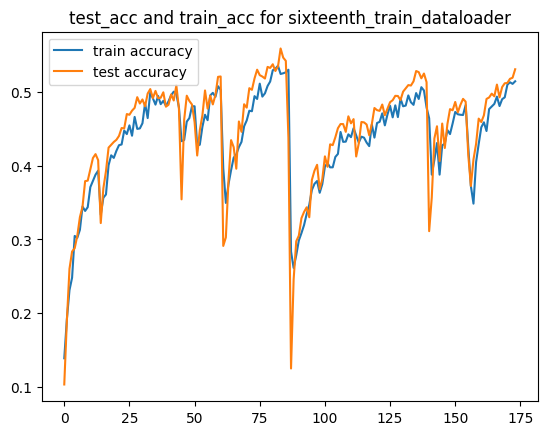

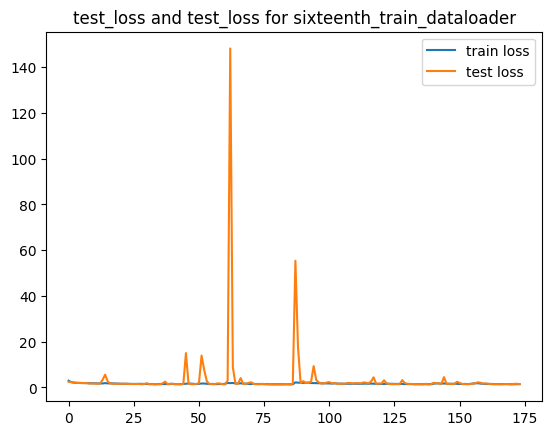

<Figure size 640x480 with 0 Axes>

In [ ]:
t = [];
for i in range(len(save_train_acc)):
  t.append(i);
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for sixteenth_train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet50_16_Acc_curve.png')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("test_loss and test_loss for sixteenth_train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet50_16_loss_curve.png')
plt.clf()
torch.save(model.state_dict(), "model_resnet50_sixteenth_train_dataloader_30iterations.pth")

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

num_classes = 10;
model.fc = nn.Linear(model.fc.in_features, num_classes);
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];
epochs = 150

for epoch in range(epochs):
    train_loss, train_acc = train(half_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch  1: Loss = 2.1171 Acc = 0.26 Test_Loss = 1.8377 Test_Acc = 0.35


100%|██████████| 40/40 [00:03<00:00, 10.30it/s]


Epoch  2: Loss = 1.7510 Acc = 0.38 Test_Loss = 1.7682 Test_Acc = 0.42


100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch  3: Loss = 1.6093 Acc = 0.44 Test_Loss = 1.6273 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Epoch  4: Loss = 1.6018 Acc = 0.45 Test_Loss = 2.4553 Test_Acc = 0.44


100%|██████████| 40/40 [00:06<00:00,  6.41it/s]


Epoch  5: Loss = 1.5356 Acc = 0.46 Test_Loss = 1.7577 Test_Acc = 0.46


100%|██████████| 40/40 [00:05<00:00,  7.99it/s]


Epoch  6: Loss = 1.4623 Acc = 0.49 Test_Loss = 1.6209 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


Epoch  7: Loss = 1.6305 Acc = 0.44 Test_Loss = 2.7368 Test_Acc = 0.40


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch  8: Loss = 1.4890 Acc = 0.47 Test_Loss = 1.3422 Test_Acc = 0.51


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch  9: Loss = 1.3717 Acc = 0.52 Test_Loss = 1.3513 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 10: Loss = 1.3551 Acc = 0.53 Test_Loss = 2.0687 Test_Acc = 0.53


100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Epoch 11: Loss = 1.3054 Acc = 0.55 Test_Loss = 1.2560 Test_Acc = 0.56


100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


Epoch 12: Loss = 1.2538 Acc = 0.56 Test_Loss = 1.2756 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 13: Loss = 1.1984 Acc = 0.58 Test_Loss = 1.5646 Test_Acc = 0.62


100%|██████████| 40/40 [00:05<00:00,  7.99it/s]


Epoch 14: Loss = 1.1947 Acc = 0.59 Test_Loss = 1.3747 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 15: Loss = 1.1749 Acc = 0.60 Test_Loss = 1.0921 Test_Acc = 0.62


100%|██████████| 40/40 [00:04<00:00,  9.69it/s]


Epoch 16: Loss = 1.1335 Acc = 0.61 Test_Loss = 58.9428 Test_Acc = 0.38


100%|██████████| 40/40 [00:05<00:00,  6.73it/s]


Epoch 17: Loss = 1.2796 Acc = 0.55 Test_Loss = 1.3150 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 18: Loss = 1.1224 Acc = 0.62 Test_Loss = 1.2149 Test_Acc = 0.65


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


Epoch 19: Loss = 1.0469 Acc = 0.64 Test_Loss = 1.7366 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 20: Loss = 1.2306 Acc = 0.60 Test_Loss = 1.1444 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 21: Loss = 1.8214 Acc = 0.40 Test_Loss = 2.8134 Test_Acc = 0.28


100%|██████████| 40/40 [00:05<00:00,  7.31it/s]


Epoch 22: Loss = 1.7687 Acc = 0.38 Test_Loss = 1.8197 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 23: Loss = 1.6549 Acc = 0.43 Test_Loss = 1.4559 Test_Acc = 0.48


100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


Epoch 24: Loss = 1.4903 Acc = 0.49 Test_Loss = 1.4233 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.40it/s]


Epoch 25: Loss = 1.3726 Acc = 0.53 Test_Loss = 1.8570 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.23it/s]


Epoch 26: Loss = 1.3687 Acc = 0.51 Test_Loss = 2.2900 Test_Acc = 0.56


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Epoch 27: Loss = 1.2655 Acc = 0.56 Test_Loss = 1.9241 Test_Acc = 0.60


100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 28: Loss = 1.1668 Acc = 0.59 Test_Loss = 1.5524 Test_Acc = 0.61


100%|██████████| 40/40 [00:04<00:00,  9.30it/s]


Epoch 29: Loss = 1.1213 Acc = 0.61 Test_Loss = 1.0812 Test_Acc = 0.63


100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Epoch 30: Loss = 1.0712 Acc = 0.63 Test_Loss = 1.2003 Test_Acc = 0.64


100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Epoch 31: Loss = 1.0555 Acc = 0.64 Test_Loss = 2.2678 Test_Acc = 0.65


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Epoch 32: Loss = 1.0501 Acc = 0.64 Test_Loss = 3.2651 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 10.73it/s]


Epoch 33: Loss = 1.1412 Acc = 0.62 Test_Loss = 403.5063 Test_Acc = 0.38


100%|██████████| 40/40 [00:03<00:00, 10.48it/s]


Epoch 34: Loss = 1.4074 Acc = 0.52 Test_Loss = 1.2327 Test_Acc = 0.60


100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


Epoch 35: Loss = 1.1501 Acc = 0.61 Test_Loss = 1.0339 Test_Acc = 0.63


100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 36: Loss = 1.2460 Acc = 0.57 Test_Loss = 2.8617 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  9.29it/s]


Epoch 37: Loss = 1.3050 Acc = 0.54 Test_Loss = 1.1327 Test_Acc = 0.61


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Epoch 38: Loss = 1.1121 Acc = 0.61 Test_Loss = 1.0909 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 39: Loss = 1.0366 Acc = 0.64 Test_Loss = 1.1362 Test_Acc = 0.63


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


Epoch 40: Loss = 1.0063 Acc = 0.66 Test_Loss = 1.0924 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 41: Loss = 0.9442 Acc = 0.67 Test_Loss = 1.0344 Test_Acc = 0.68


100%|██████████| 40/40 [00:04<00:00,  8.92it/s]


Epoch 42: Loss = 0.9088 Acc = 0.69 Test_Loss = 1.0936 Test_Acc = 0.68


100%|██████████| 40/40 [00:04<00:00,  8.91it/s]


Epoch 43: Loss = 0.8975 Acc = 0.69 Test_Loss = 0.9612 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch 44: Loss = 0.9165 Acc = 0.69 Test_Loss = 1.0204 Test_Acc = 0.70


100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


Epoch 45: Loss = 0.9046 Acc = 0.69 Test_Loss = 0.9399 Test_Acc = 0.68


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch 46: Loss = 0.8653 Acc = 0.71 Test_Loss = 1.8160 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 47: Loss = 0.8341 Acc = 0.72 Test_Loss = 0.8784 Test_Acc = 0.72


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 48: Loss = 0.8152 Acc = 0.72 Test_Loss = 0.8923 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  8.12it/s]


Epoch 49: Loss = 0.7812 Acc = 0.73 Test_Loss = 0.8129 Test_Acc = 0.73


100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


Epoch 50: Loss = 0.7707 Acc = 0.74 Test_Loss = 0.8528 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch 51: Loss = 0.8833 Acc = 0.70 Test_Loss = 0.9309 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 52: Loss = 0.7813 Acc = 0.73 Test_Loss = 0.8899 Test_Acc = 0.73


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Epoch 53: Loss = 0.7623 Acc = 0.74 Test_Loss = 0.9272 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  9.96it/s]


Epoch 54: Loss = 0.7882 Acc = 0.73 Test_Loss = 0.8416 Test_Acc = 0.71


100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Epoch 55: Loss = 0.8219 Acc = 0.72 Test_Loss = 1.2030 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 56: Loss = 1.0366 Acc = 0.64 Test_Loss = 4.1171 Test_Acc = 0.53


100%|██████████| 40/40 [00:05<00:00,  7.20it/s]


Epoch 57: Loss = 0.9152 Acc = 0.68 Test_Loss = 0.8198 Test_Acc = 0.71


100%|██████████| 40/40 [00:05<00:00,  7.99it/s]


Epoch 58: Loss = 0.7609 Acc = 0.74 Test_Loss = 0.7843 Test_Acc = 0.73


100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


Epoch 59: Loss = 0.7203 Acc = 0.75 Test_Loss = 0.7270 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.73it/s]


Epoch 60: Loss = 0.7735 Acc = 0.74 Test_Loss = 0.9374 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Epoch 61: Loss = 0.7098 Acc = 0.76 Test_Loss = 0.9314 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 62: Loss = 0.6897 Acc = 0.77 Test_Loss = 0.7883 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  8.15it/s]


Epoch 63: Loss = 0.7464 Acc = 0.75 Test_Loss = 0.9374 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 64: Loss = 0.6902 Acc = 0.77 Test_Loss = 1.6662 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


Epoch 65: Loss = 0.6799 Acc = 0.77 Test_Loss = 0.7574 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 66: Loss = 0.6575 Acc = 0.78 Test_Loss = 0.6997 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch 67: Loss = 0.6869 Acc = 0.77 Test_Loss = 0.8244 Test_Acc = 0.72


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


Epoch 68: Loss = 0.6918 Acc = 0.77 Test_Loss = 0.8960 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 69: Loss = 0.6493 Acc = 0.78 Test_Loss = 0.6912 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.02it/s]


Epoch 70: Loss = 0.6069 Acc = 0.79 Test_Loss = 0.7715 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 71: Loss = 0.6051 Acc = 0.79 Test_Loss = 0.6692 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Epoch 72: Loss = 0.5730 Acc = 0.80 Test_Loss = 0.6466 Test_Acc = 0.78


100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


Epoch 73: Loss = 0.5579 Acc = 0.81 Test_Loss = 0.6371 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  8.91it/s]


Epoch 74: Loss = 0.5603 Acc = 0.80 Test_Loss = 0.6725 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 75: Loss = 0.6444 Acc = 0.78 Test_Loss = 0.8479 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 76: Loss = 0.9181 Acc = 0.69 Test_Loss = 1.1084 Test_Acc = 0.61


100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


Epoch 77: Loss = 0.8235 Acc = 0.71 Test_Loss = 1.0204 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.86it/s]


Epoch 78: Loss = 0.6636 Acc = 0.77 Test_Loss = 1.0817 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.95it/s]


Epoch 79: Loss = 0.6056 Acc = 0.79 Test_Loss = 1.0555 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 80: Loss = 0.6318 Acc = 0.78 Test_Loss = 0.7691 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 81: Loss = 1.1182 Acc = 0.64 Test_Loss = 2.2861 Test_Acc = 0.49


100%|██████████| 40/40 [00:05<00:00,  7.16it/s]


Epoch 82: Loss = 1.7622 Acc = 0.39 Test_Loss = 1.4631 Test_Acc = 0.47


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 83: Loss = 1.4091 Acc = 0.50 Test_Loss = 1.5872 Test_Acc = 0.53


100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch 84: Loss = 1.3131 Acc = 0.54 Test_Loss = 1.2296 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 85: Loss = 1.1886 Acc = 0.58 Test_Loss = 1.0869 Test_Acc = 0.63


100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 86: Loss = 1.0703 Acc = 0.63 Test_Loss = 0.9293 Test_Acc = 0.67


100%|██████████| 40/40 [00:05<00:00,  7.30it/s]


Epoch 87: Loss = 0.9496 Acc = 0.67 Test_Loss = 0.8494 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 88: Loss = 0.8613 Acc = 0.70 Test_Loss = 0.8210 Test_Acc = 0.71


100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Epoch 89: Loss = 0.8533 Acc = 0.70 Test_Loss = 0.9591 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 90: Loss = 0.8094 Acc = 0.72 Test_Loss = 0.7705 Test_Acc = 0.73


100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 91: Loss = 0.7286 Acc = 0.74 Test_Loss = 0.7262 Test_Acc = 0.75


100%|██████████| 40/40 [00:05<00:00,  6.94it/s]


Epoch 92: Loss = 0.6831 Acc = 0.76 Test_Loss = 0.7122 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Epoch 93: Loss = 0.6504 Acc = 0.77 Test_Loss = 0.6882 Test_Acc = 0.76


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Epoch 94: Loss = 0.6378 Acc = 0.77 Test_Loss = 0.6889 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 95: Loss = 0.6334 Acc = 0.78 Test_Loss = 0.7010 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch 96: Loss = 0.6107 Acc = 0.78 Test_Loss = 0.6707 Test_Acc = 0.77


100%|██████████| 40/40 [00:05<00:00,  7.42it/s]


Epoch 97: Loss = 0.5994 Acc = 0.79 Test_Loss = 0.6790 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 98: Loss = 0.5796 Acc = 0.80 Test_Loss = 0.6346 Test_Acc = 0.77


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 99: Loss = 0.5489 Acc = 0.80 Test_Loss = 0.6350 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 100: Loss = 0.5347 Acc = 0.81 Test_Loss = 0.6240 Test_Acc = 0.78


100%|██████████| 40/40 [00:05<00:00,  7.17it/s]


Epoch 101: Loss = 0.5337 Acc = 0.81 Test_Loss = 0.6044 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch 102: Loss = 0.5161 Acc = 0.82 Test_Loss = 0.6372 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 10.59it/s]


Epoch 103: Loss = 0.5055 Acc = 0.82 Test_Loss = 0.6212 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch 104: Loss = 0.5017 Acc = 0.82 Test_Loss = 0.6235 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


Epoch 105: Loss = 0.4886 Acc = 0.83 Test_Loss = 0.6254 Test_Acc = 0.79


100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Epoch 106: Loss = 0.4763 Acc = 0.83 Test_Loss = 0.6009 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 107: Loss = 0.4750 Acc = 0.83 Test_Loss = 0.6035 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.46it/s]


Epoch 108: Loss = 0.4684 Acc = 0.83 Test_Loss = 0.5946 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 109: Loss = 0.4554 Acc = 0.84 Test_Loss = 0.6238 Test_Acc = 0.79


100%|██████████| 40/40 [00:05<00:00,  6.90it/s]


Epoch 110: Loss = 0.4501 Acc = 0.84 Test_Loss = 0.6023 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


Epoch 111: Loss = 0.4402 Acc = 0.84 Test_Loss = 0.6125 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 112: Loss = 0.4479 Acc = 0.84 Test_Loss = 0.6060 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


Epoch 113: Loss = 0.4319 Acc = 0.85 Test_Loss = 0.6022 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 114: Loss = 0.4290 Acc = 0.85 Test_Loss = 0.5962 Test_Acc = 0.80


100%|██████████| 40/40 [00:05<00:00,  7.48it/s]


Epoch 115: Loss = 0.4207 Acc = 0.85 Test_Loss = 0.6038 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.40it/s]


Epoch 116: Loss = 0.4186 Acc = 0.85 Test_Loss = 0.5983 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.74it/s]


Epoch 117: Loss = 0.4124 Acc = 0.85 Test_Loss = 0.5998 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


Epoch 118: Loss = 0.4052 Acc = 0.86 Test_Loss = 0.5948 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch 119: Loss = 0.4001 Acc = 0.86 Test_Loss = 0.5910 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


Epoch 120: Loss = 0.3915 Acc = 0.86 Test_Loss = 0.6096 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 121: Loss = 0.3833 Acc = 0.86 Test_Loss = 0.6030 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.47it/s]


Epoch 122: Loss = 0.3904 Acc = 0.86 Test_Loss = 0.6219 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.58it/s]


Epoch 123: Loss = 0.3814 Acc = 0.86 Test_Loss = 0.6067 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


Epoch 124: Loss = 0.3733 Acc = 0.87 Test_Loss = 0.6072 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 125: Loss = 0.3673 Acc = 0.87 Test_Loss = 0.5978 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  9.87it/s]


Epoch 126: Loss = 0.3611 Acc = 0.87 Test_Loss = 0.5979 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Epoch 127: Loss = 0.3698 Acc = 0.87 Test_Loss = 0.6362 Test_Acc = 0.80


100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Epoch 128: Loss = 0.3564 Acc = 0.88 Test_Loss = 0.6041 Test_Acc = 0.81


100%|██████████| 40/40 [00:05<00:00,  6.78it/s]


Epoch 129: Loss = 0.3451 Acc = 0.88 Test_Loss = 0.6070 Test_Acc = 0.81


100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


Epoch 130: Loss = 0.3507 Acc = 0.87 Test_Loss = 0.6011 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 131: Loss = 0.3417 Acc = 0.88 Test_Loss = 0.6202 Test_Acc = 0.81


100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


Epoch 132: Loss = 0.3415 Acc = 0.88 Test_Loss = 0.6120 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 133: Loss = 0.3304 Acc = 0.88 Test_Loss = 0.6465 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.11it/s]


Epoch 134: Loss = 0.3250 Acc = 0.88 Test_Loss = 0.6138 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


Epoch 135: Loss = 0.3243 Acc = 0.88 Test_Loss = 0.6032 Test_Acc = 0.81


100%|██████████| 40/40 [00:05<00:00,  6.93it/s]


Epoch 136: Loss = 0.3230 Acc = 0.88 Test_Loss = 0.6130 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 137: Loss = 0.3113 Acc = 0.89 Test_Loss = 0.6045 Test_Acc = 0.82


100%|██████████| 40/40 [00:05<00:00,  7.09it/s]


Epoch 138: Loss = 0.3134 Acc = 0.89 Test_Loss = 0.7026 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.46it/s]


Epoch 139: Loss = 0.3070 Acc = 0.89 Test_Loss = 0.6259 Test_Acc = 0.81


100%|██████████| 40/40 [00:06<00:00,  5.98it/s]


Epoch 140: Loss = 0.3058 Acc = 0.89 Test_Loss = 0.6033 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 141: Loss = 0.9735 Acc = 0.70 Test_Loss = 1.3850 Test_Acc = 0.54


100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


Epoch 142: Loss = 1.2455 Acc = 0.59 Test_Loss = 0.9364 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 143: Loss = 0.8517 Acc = 0.71 Test_Loss = 0.8572 Test_Acc = 0.72


100%|██████████| 40/40 [00:05<00:00,  7.51it/s]


Epoch 144: Loss = 0.7226 Acc = 0.76 Test_Loss = 0.9543 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


Epoch 145: Loss = 0.6872 Acc = 0.77 Test_Loss = 0.7343 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.39it/s]


Epoch 146: Loss = 0.6194 Acc = 0.79 Test_Loss = 0.6897 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


Epoch 147: Loss = 0.5939 Acc = 0.80 Test_Loss = 0.6468 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 10.70it/s]


Epoch 148: Loss = 0.5555 Acc = 0.81 Test_Loss = 0.6460 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.98it/s]


Epoch 149: Loss = 0.5186 Acc = 0.83 Test_Loss = 0.7915 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]

Epoch 150: Loss = 0.4532 Acc = 0.85 Test_Loss = 0.6218 Test_Acc = 0.80
Done!


In [ ]:
t = [];
for i in range(len(save_train_acc)):
  t.append(i);
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for half_train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet50_2_Acc_curve.png')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("test_loss and train_loss for half_train_dataloader")
plt.legend()
plt.show()

#plt.savefig('/content/drive/MyDrive/Computer_vision/restnet50_2_loss_curve.png')
plt.clf()

torch.save(model.state_dict(), "model_resnet50_half_train_dataloader_30iterations.pth")

NameError: ignored

## Codes for Problem 3

In [ ]:
# TODO: Try to achieve the best performance given all training data using whatever model and training strategy.
# (New) (You cannot use the model that was pretrained on CIFAR10)

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(180),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
model = models.densenet121(pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()
    con=0
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        con=con+len(y);
        # Compute prediction error
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / con

    return avg_epoch_loss, avg_acc

In [ ]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
import os

In [ ]:
save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];

In [ ]:
#model.load_state_dict(torch.load("/content/drive/MyDrive/Computer_vision/densenet121_100it_2.pth"))
## already train 100, now train 200~300 with data_rotation

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
epochs = 100
# save_folder = "/content/drive/MyDrive/Computer_vision"
for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    #torch.save(model.state_dict(), os.path.join(save_folder,"densenet121_100it_4.pth"))
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Epoch  1: Loss = 0.1406 Acc = 0.95 Test_Loss = 0.3465 Test_Acc = 0.89


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch  2: Loss = 0.1321 Acc = 0.95 Test_Loss = 0.3472 Test_Acc = 0.89


100%|██████████| 40/40 [00:05<00:00,  6.75it/s]


Epoch  3: Loss = 0.1294 Acc = 0.95 Test_Loss = 0.3508 Test_Acc = 0.89


  7%|▋         | 13/196 [00:03<00:45,  4.02it/s]


KeyboardInterrupt: ignored

In [ ]:
matplotlib.use('Agg')
t = [];
for i in range(len(save_train_acc)):
  t.append(i);
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/densenet_whole_Acc_curve.png')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("test_loss and train_loss for train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/densenet_whole_loss_curve.png')
plt.clf()

## Problems

1. (30%) Finish the rest of the codes for Problem 1 and Problem 2 according to the hint. (2 code cells in total.)
2. Train small model (resnet18) and big model (resnet50) from scratch on `sixteenth_train_dataloader`, `half_train_dataloader`, and `train_dataloader` respectively.
3. (30%) Achieve the best performance given all training data using whatever model and training strategy.  
  (You cannot use the model that was pretrained on CIFAR10)



## Discussion

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()
    con=0
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        con=con+len(y);
        # Compute prediction error
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / con

    return avg_epoch_loss, avg_acc

In [ ]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="IMAGENET1K_V1")

num_classes = 10;
model.fc = nn.Linear(model.fc.in_features, num_classes);
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_folder = "/content/drive/MyDrive/Computer_vision"

save_train_loss = [];
save_train_acc = [];
save_test_loss = [];
save_test_acc = [];

epochs = 100
for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    save_train_loss.append(train_loss);
    save_train_acc.append(train_acc);
    save_test_loss.append(test_loss);
    save_test_acc.append(test_acc);
    torch.save(model.state_dict(), os.path.join(save_folder,"densenet121_100it.pth"))
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
100%|██████████| 40/40 [00:04<00:00,  9.67it/s]


Epoch  1: Loss = 0.9427 Acc = 0.68 Test_Loss = 0.7547 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  8.84it/s]


Epoch  2: Loss = 0.6358 Acc = 0.78 Test_Loss = 0.5975 Test_Acc = 0.79


100%|██████████| 40/40 [00:05<00:00,  7.23it/s]


Epoch  3: Loss = 0.5417 Acc = 0.81 Test_Loss = 0.5430 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 12.23it/s]


Epoch  4: Loss = 0.5013 Acc = 0.83 Test_Loss = 0.5764 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 12.05it/s]


Epoch  5: Loss = 0.4750 Acc = 0.84 Test_Loss = 0.6143 Test_Acc = 0.80


100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Epoch  6: Loss = 1.0220 Acc = 0.66 Test_Loss = 0.7531 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Epoch  7: Loss = 0.6165 Acc = 0.79 Test_Loss = 0.5350 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.96it/s]


Epoch  8: Loss = 0.4757 Acc = 0.84 Test_Loss = 0.5150 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.55it/s]


Epoch  9: Loss = 0.4252 Acc = 0.85 Test_Loss = 0.4746 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.09it/s]


Epoch 10: Loss = 0.3892 Acc = 0.87 Test_Loss = 0.4527 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  8.16it/s]


Epoch 11: Loss = 0.3695 Acc = 0.87 Test_Loss = 0.4455 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 12: Loss = 0.3606 Acc = 0.87 Test_Loss = 0.4265 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 13: Loss = 0.3437 Acc = 0.88 Test_Loss = 0.4240 Test_Acc = 0.86


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Epoch 14: Loss = 0.3255 Acc = 0.89 Test_Loss = 0.4267 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch 15: Loss = 0.3129 Acc = 0.89 Test_Loss = 0.4209 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.72it/s]


Epoch 16: Loss = 0.3002 Acc = 0.89 Test_Loss = 0.4309 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 17: Loss = 0.2904 Acc = 0.90 Test_Loss = 0.4268 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Epoch 18: Loss = 0.2778 Acc = 0.90 Test_Loss = 0.4281 Test_Acc = 0.86


100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


Epoch 19: Loss = 0.2786 Acc = 0.90 Test_Loss = 0.4148 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


Epoch 20: Loss = 0.2635 Acc = 0.91 Test_Loss = 0.4120 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 21: Loss = 0.2548 Acc = 0.91 Test_Loss = 0.4198 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Epoch 22: Loss = 0.2451 Acc = 0.91 Test_Loss = 0.4224 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


Epoch 23: Loss = 0.2512 Acc = 0.91 Test_Loss = 0.4339 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Epoch 24: Loss = 0.2358 Acc = 0.92 Test_Loss = 0.4146 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 25: Loss = 0.2285 Acc = 0.92 Test_Loss = 0.4297 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


Epoch 26: Loss = 0.2280 Acc = 0.92 Test_Loss = 0.4134 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.63it/s]


Epoch 27: Loss = 0.2155 Acc = 0.92 Test_Loss = 0.4192 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 28: Loss = 0.2086 Acc = 0.93 Test_Loss = 0.4470 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 29: Loss = 0.2036 Acc = 0.93 Test_Loss = 0.4320 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.35it/s]


Epoch 30: Loss = 0.1982 Acc = 0.93 Test_Loss = 0.4593 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


Epoch 31: Loss = 0.1900 Acc = 0.93 Test_Loss = 0.4348 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


Epoch 32: Loss = 0.1898 Acc = 0.93 Test_Loss = 0.4735 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 33: Loss = 0.1814 Acc = 0.94 Test_Loss = 0.4399 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


Epoch 34: Loss = 0.1750 Acc = 0.94 Test_Loss = 0.4500 Test_Acc = 0.87


100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


Epoch 35: Loss = 0.1750 Acc = 0.94 Test_Loss = 0.4378 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 36: Loss = 0.1664 Acc = 0.94 Test_Loss = 0.4208 Test_Acc = 0.88


100%|██████████| 40/40 [00:05<00:00,  7.34it/s]


Epoch 37: Loss = 0.1666 Acc = 0.94 Test_Loss = 0.4387 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.64it/s]


Epoch 38: Loss = 0.1589 Acc = 0.94 Test_Loss = 0.4740 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.35it/s]


Epoch 39: Loss = 0.1524 Acc = 0.95 Test_Loss = 0.4631 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.13it/s]


Epoch 40: Loss = 0.1532 Acc = 0.95 Test_Loss = 0.4527 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 41: Loss = 0.1457 Acc = 0.95 Test_Loss = 0.5002 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.19it/s]


Epoch 42: Loss = 0.1452 Acc = 0.95 Test_Loss = 0.4727 Test_Acc = 0.87


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Epoch 43: Loss = 0.1382 Acc = 0.95 Test_Loss = 0.4897 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 44: Loss = 0.1354 Acc = 0.95 Test_Loss = 0.4655 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.01it/s]


Epoch 45: Loss = 0.1324 Acc = 0.95 Test_Loss = 0.4693 Test_Acc = 0.88


100%|██████████| 40/40 [00:05<00:00,  7.91it/s]


Epoch 46: Loss = 0.1312 Acc = 0.95 Test_Loss = 0.5328 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.18it/s]


Epoch 47: Loss = 0.1716 Acc = 0.94 Test_Loss = 0.5119 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 48: Loss = 0.1660 Acc = 0.94 Test_Loss = 0.4431 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.10it/s]


Epoch 49: Loss = 0.1304 Acc = 0.95 Test_Loss = 0.4403 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


Epoch 50: Loss = 0.1232 Acc = 0.96 Test_Loss = 0.4506 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 51: Loss = 0.1128 Acc = 0.96 Test_Loss = 0.4813 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.49it/s]


Epoch 52: Loss = 0.1136 Acc = 0.96 Test_Loss = 0.5279 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


Epoch 53: Loss = 0.1154 Acc = 0.96 Test_Loss = 0.4489 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch 54: Loss = 0.1124 Acc = 0.96 Test_Loss = 0.4713 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


Epoch 55: Loss = 0.1068 Acc = 0.96 Test_Loss = 0.4744 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


Epoch 56: Loss = 0.1078 Acc = 0.96 Test_Loss = 0.4770 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Epoch 57: Loss = 0.1017 Acc = 0.96 Test_Loss = 0.4606 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 58: Loss = 0.1032 Acc = 0.96 Test_Loss = 0.5056 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 59: Loss = 0.0986 Acc = 0.97 Test_Loss = 0.4838 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.87it/s]


Epoch 60: Loss = 0.0962 Acc = 0.97 Test_Loss = 0.4841 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 61: Loss = 0.0989 Acc = 0.97 Test_Loss = 0.4668 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Epoch 62: Loss = 0.0984 Acc = 0.97 Test_Loss = 0.4688 Test_Acc = 0.89


100%|██████████| 40/40 [00:05<00:00,  7.20it/s]


Epoch 63: Loss = 0.0931 Acc = 0.97 Test_Loss = 0.5057 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 64: Loss = 0.0895 Acc = 0.97 Test_Loss = 0.4641 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.21it/s]


Epoch 65: Loss = 0.0900 Acc = 0.97 Test_Loss = 0.4774 Test_Acc = 0.88


100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


Epoch 66: Loss = 0.0912 Acc = 0.97 Test_Loss = 0.5163 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 67: Loss = 0.0904 Acc = 0.97 Test_Loss = 0.5050 Test_Acc = 0.88


100%|██████████| 40/40 [00:05<00:00,  6.90it/s]


Epoch 68: Loss = 0.0871 Acc = 0.97 Test_Loss = 0.5238 Test_Acc = 0.87


100%|██████████| 40/40 [00:05<00:00,  7.80it/s]


Epoch 69: Loss = 0.1079 Acc = 0.96 Test_Loss = 0.4984 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.46it/s]


Epoch 70: Loss = 0.0855 Acc = 0.97 Test_Loss = 0.5066 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Epoch 71: Loss = 0.0846 Acc = 0.97 Test_Loss = 0.5115 Test_Acc = 0.88


100%|██████████| 40/40 [00:05<00:00,  6.98it/s]


Epoch 72: Loss = 0.0822 Acc = 0.97 Test_Loss = 0.5256 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.45it/s]


Epoch 73: Loss = 0.0798 Acc = 0.97 Test_Loss = 0.5080 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch 74: Loss = 0.0752 Acc = 0.97 Test_Loss = 0.5003 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.10it/s]


Epoch 75: Loss = 0.0757 Acc = 0.97 Test_Loss = 0.5836 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 76: Loss = 0.0785 Acc = 0.97 Test_Loss = 0.5501 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.95it/s]


Epoch 77: Loss = 0.0780 Acc = 0.97 Test_Loss = 0.5371 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


Epoch 78: Loss = 0.0737 Acc = 0.97 Test_Loss = 0.5124 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 79: Loss = 0.0728 Acc = 0.97 Test_Loss = 0.5346 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Epoch 80: Loss = 0.0704 Acc = 0.98 Test_Loss = 0.5314 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


Epoch 81: Loss = 0.0807 Acc = 0.97 Test_Loss = 0.5033 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Epoch 82: Loss = 0.0760 Acc = 0.97 Test_Loss = 0.5113 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.88it/s]


Epoch 83: Loss = 0.0736 Acc = 0.97 Test_Loss = 0.5066 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Epoch 84: Loss = 0.0681 Acc = 0.98 Test_Loss = 0.5475 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.90it/s]


Epoch 85: Loss = 0.0657 Acc = 0.98 Test_Loss = 0.5144 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 86: Loss = 0.0620 Acc = 0.98 Test_Loss = 0.5491 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 87: Loss = 0.0665 Acc = 0.98 Test_Loss = 0.5261 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 88: Loss = 0.0682 Acc = 0.98 Test_Loss = 0.5297 Test_Acc = 0.88


100%|██████████| 40/40 [00:05<00:00,  7.82it/s]


Epoch 89: Loss = 0.0629 Acc = 0.98 Test_Loss = 0.5422 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 90: Loss = 0.0615 Acc = 0.98 Test_Loss = 0.5903 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 91: Loss = 0.5479 Acc = 0.84 Test_Loss = 0.4781 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


Epoch 92: Loss = 0.3616 Acc = 0.89 Test_Loss = 0.5739 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.17it/s]


Epoch 93: Loss = 0.1592 Acc = 0.94 Test_Loss = 0.4605 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


Epoch 94: Loss = 0.1080 Acc = 0.96 Test_Loss = 0.4748 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 95: Loss = 0.0833 Acc = 0.97 Test_Loss = 0.4653 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


Epoch 96: Loss = 0.0665 Acc = 0.98 Test_Loss = 0.5030 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch 97: Loss = 0.0606 Acc = 0.98 Test_Loss = 0.5032 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 98: Loss = 0.0579 Acc = 0.98 Test_Loss = 0.5089 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Epoch 99: Loss = 0.0544 Acc = 0.98 Test_Loss = 0.5226 Test_Acc = 0.88


100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


Epoch 100: Loss = 0.0535 Acc = 0.98 Test_Loss = 0.5208 Test_Acc = 0.89
Done!


In [ ]:
matplotlib.use('Agg')
t = [];
for i in range(len(save_train_acc)):
  t.append(i);
plt.plot(t,save_train_acc,label = "train accuracy")
plt.plot(t,save_test_acc,label="test accuracy")
plt.title("test_acc and train_acc for half_train_dataloader")
plt.legend()
plt.show()
#plt.savefig(f'/content/drive/MyDrive/Computer_vision/restnet50_with_pretrained_whole_Acc_curve.png')
plt.clf()

plt.plot(t,save_train_loss,label = "train loss")
plt.plot(t,save_test_loss,label="test loss")
plt.title("test_loss and train_loss for half_train_dataloader")
plt.legend()
plt.show()

#plt.savefig('/content/drive/MyDrive/Computer_vision/restnet50_with_pretrained_whole_loss_curve.png')
plt.clf()

Write down your insights in the report. The file name should be report.pdf.
For the following discussion, please present the results graphically as shown in Fig. 1 and discuss them.

- (30%) The relationship between the accuracy, model size, and the training dataset size.  
    (Total 6 models. Small model trains on the sixteenth, half, and all data. Big model trains on the sixteenth, half, and all data. If the result is different from Fig.1, please explain the possible reasons.)
- (10%) What if we train the ResNet with ImageNet initialized weights (`weights="IMAGENET1K_V1"`).
Please explain why the relationship changed this way?

Hint: You can try different hyperparameters combinations when training the models.

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)